In [1]:
from importlib import reload
import imports.tkinterImports
reload(imports.tkinterImports)
from imports.tkinterImports import *

import imports.otherImports
reload(imports.otherImports)
from imports.otherImports import *

import imports.dataProcessingImports
reload(imports.dataProcessingImports)
from imports.dataProcessingImports import *

import imports.modelImports
reload(imports.modelImports)
from imports.modelImports import *

import imports.torchImports
reload(imports.torchImports)
from imports.torchImports import *

import imports.metricsImports
reload(imports.metricsImports)
from imports.metricsImports import *


In [2]:

data_path = r'Data\train.csv'
temp_data = pd.read_csv(data_path, index_col=['Id'])

train_data = pd.DataFrame(temp_data)


In [3]:

# Linear model data configuration
lin_X = train_data.drop(columns=['Pawpularity'])
lin_y = train_data['Pawpularity']
random = 30997
X_train, X_test, y_train, y_test = train_test_split(lin_X,lin_y,test_size=0.2,random_state=random)


In [4]:
columns =   ["Occlusion", "Near", "Subject Focus", "Group"]
logiX = train_data[columns]
logiy = train_data['Human'].values
logiX_train, logiX_test,logiy_train,logiy_test = train_test_split(logiX,logiy,test_size=0.2,random_state=random)



In [5]:
def get_roccurve(model, X_test_data: npt.ArrayLike, y_test_data: npt.ArrayLike, reg_type_name: str = ""):
    y_pred_proba = model.predict_proba(X=X_test_data)[:,1]
    [fpr, tpr, thr] = roc_curve(y_test_data, y_pred_proba)
    auc (fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='coral', label = 'ROC Curve with Area Under Curve ='+str(auc (fpr, tpr)))
    plt.xlabel('False positive Rate (1 - specificity)')
    plt.ylabel('True Positive Rate ')
    plt.legend(loc='lower right')
    plt.savefig("./static/roccurve_" + reg_type_name + ".png")



In [6]:
def get_performancemetrics(model, X_test_data: npt.ArrayLike, y_test_data: npt.ArrayLike, model_type_name: str = ""):
    y_pred = model.predict(X_test_data)
    p = precision_score(y_test_data, y_pred, average='micro')
    r = recall_score(y_test_data, y_pred, average='micro')
    f = f1_score(y_test_data, y_pred, average='micro')
    a = accuracy_score(y_test_data,y_pred)
    return "Here're the metrics for the trained model(" + model_type_name + "):\nPrecision:\t{}\nRecall:\t\t{}\nF-Score:\t\t{}\nAccuracy:\t{}".format(p,r,f,a)




In [7]:
def do_crossvalidation():
    kf = KFold(n_splits=5)
    kf.get_n_splits(lin_X)

    score_history = []
    for train, test in kf.split(lin_X, lin_y):
        reg = LinearRegression()
        reg.fit(lin_X.values[train,:], lin_y.iloc[train])
        y_pred = reg.predict(lin_X.values[test,:])
        score_history.append(reg.score(lin_X.values[test,:], lin_y.iloc[test]))
    return '\n'.join(map(str, score_history))



In [8]:
kmean_columns = ['Pawpularity']
kmean_data = train_data.drop(columns=kmean_columns)
scaler = MinMaxScaler()
kmean_data_scaled = pd.DataFrame(scaler.fit_transform(kmean_data))


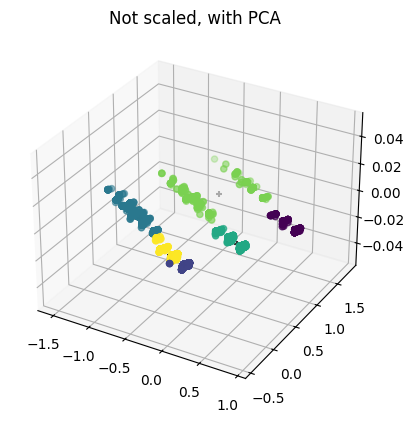

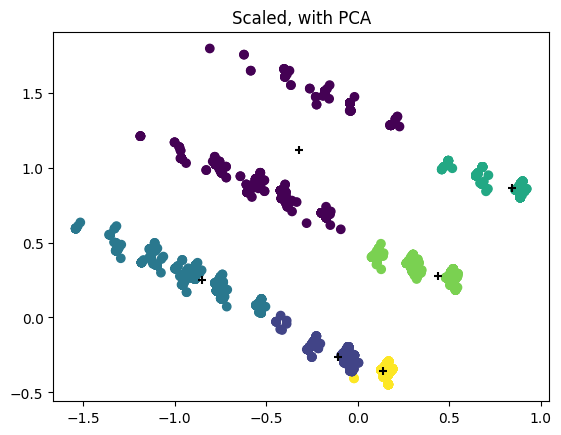

In [9]:
pca = PCA(n_components=2)
clusters = 6

X_pca = pca.fit_transform(kmean_data)
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(X_pca)
kmean_pred = kmeans.predict(X_pca)

X_pca_scaled = pca.fit_transform(kmean_data_scaled)
kmeans_with_scaled = KMeans(n_clusters=clusters)
kmeans_with_scaled.fit(X_pca_scaled)
kmean_pred_from_scaled = kmeans_with_scaled.predict(X_pca_scaled)

# fig1, ax1 = plt.subplots()
fig1 = plt.figure()
ax1 = plt.axes(projection='3d')
fig2, ax2 = plt.subplots()

ax1.scatter(X_pca[:,0], X_pca[:,1], c=kmean_pred)
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', marker='+')
ax1.set_title("Not scaled, with PCA")
fig1.savefig("./static/kmeansplot_early_pca_noscale.png")

# X_pca = pca.fit_transform(kmean_data_scaled)
ax2.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=kmean_pred_from_scaled)
ax2.scatter(kmeans_with_scaled.cluster_centers_[:,0], kmeans_with_scaled.cluster_centers_[:,1], c='black', marker='+')
ax2.set_title("Scaled, with PCA")
fig2.savefig("./static/kmeansplot_early_pca_scale.png")


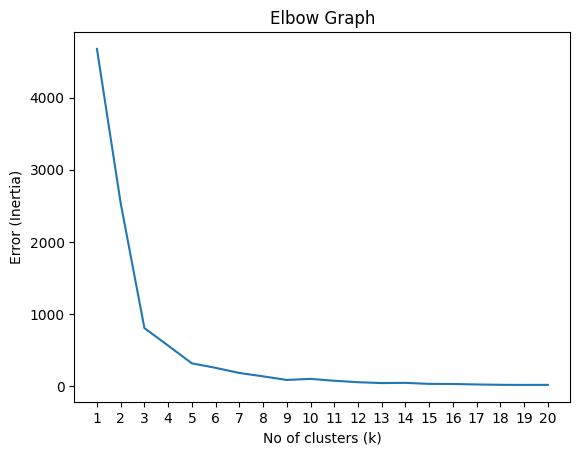

In [10]:
error = []
for i in range(1,21):
 kmeans = KMeans(n_clusters=i).fit(X_pca_scaled)
 error.append(kmeans.inertia_)

plt.plot(range(1,21), error)
plt.title("Elbow Graph")
plt.xlabel("No of clusters (k)")
plt.ylabel("Error (Inertia)")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.savefig("static/kmeans_pca_scaled_elbowgraph.png")



0.5549277814982568
0.5549277814982568


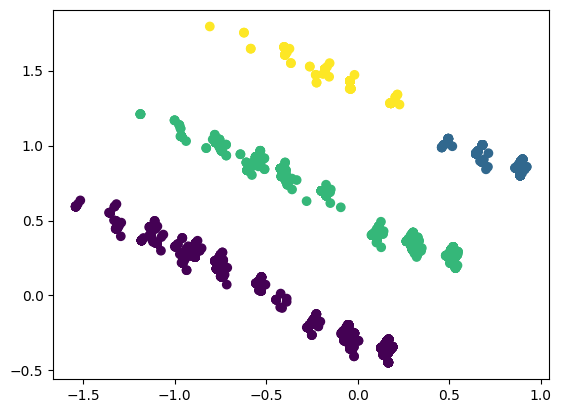

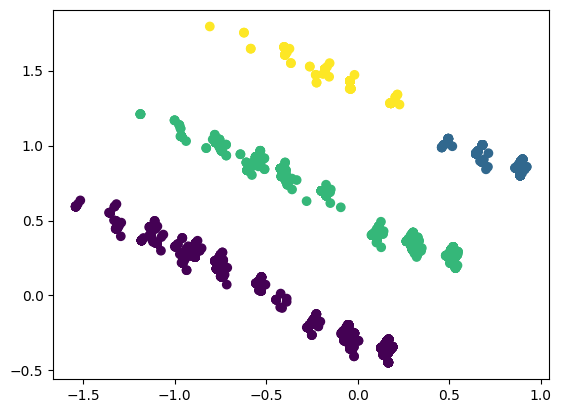

In [11]:
from sklearn.cluster import DBSCAN
eps = 0.3
fig1, ax1 = plt.subplots()
dbscan = DBSCAN(eps=eps, min_samples=2)
y= dbscan.fit_predict(X_pca)
ax1.scatter(X_pca[:,0], X_pca[:,1], c=y)
print(metrics.silhouette_score(X_pca, y))
fig1.savefig("static/DBScan_noscale.png")

fig2, ax2 = plt.subplots()
dbscan_scaled = DBSCAN(eps=eps, min_samples=2)
y_scaled= dbscan_scaled.fit_predict(X_pca_scaled)
ax2.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=y_scaled)
print(metrics.silhouette_score(X_pca_scaled, y_scaled))
fig2.savefig("static/DBScan_withscale.png")



In [12]:
def image_kmeans(path: str, clusters: int = 5):
    source_image = cv2.imread(path)
    image = cv2.cvtColor(source_image, cv2.COLOR_RGB2BGR)
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    K=clusters
    _, labels, (centers) = cv2.kmeans(pixel_values, K, None, criteria, 10,
    cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.flatten()

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    plt.figure(figsize=(10,10))
    fig, axs = plt.subplots(1,2)

    axs[0].imshow(image)
    axs[0].set_title("oprindelige billede")
    axs[1].imshow(segmented_image)
    axs[1].set_title("K-means clustering på billede")
    plt.savefig("static/clustered_image.png")



In [13]:
# Definerer det neutrale netværks model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(X_train_tensor.shape[1], 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [14]:
class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label



In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        self.fully_connected_layer_1 = nn.Linear(in_features=32*7*7, out_features=64)
        self.drop = nn.Dropout(0.25)
        self.fully_connected_layer_2 = nn.Linear(in_features=64, out_features=64)
        self.fully_connected_layer_3 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, x):
        out = self.convlayer(x)
        out = out.view(out.size(0), -1)
        out = self.fully_connected_layer_1(out)
        out = self.drop(out)
        out = self.fully_connected_layer_2(out)
        out = self.fully_connected_layer_3(out)
        return out



In [16]:
class ImageDatasetForMultilabelFromCSV(Dataset):
    def __init__(self, labels_df, image_dir, transform=None, file_extension='.jpg'):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform = transform
        self.file_extension = file_extension


    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels_df.iloc[idx, 0] + self.file_extension)
        image = Image.open(img_name)
        labels = torch.tensor(self.labels_df.iloc[idx, 1:].values.astype('float32'))

        if self.transform:
            image = self.transform(image)

        return image, labels

class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelCNN, self).__init__()
        self.multi_model = models.resnet18(pretrained=True)
        self.multi_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.multi_model.fc = nn.Linear(self.multi_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.multi_model(x)
    

In [17]:
class ModelHolder():
    def __init__(self):
        self.lin_reg = torch.load("models/linear_regression.pt")
        self.log_reg_for_human = torch.load("models/logistic_regression.pt")
        self.gaussian_bayes_model = torch.load("models/gaussian_naive_bayes.pt")
        self.multinomial_bayes_model = torch.load("models/multinomial_naive_bayes.pt")
        self.rfc_bagging_model = torch.load("models/randomForestClassifier_with_bagging.pt")
        self.decisionTree_boosting_model = torch.load("models/decisionTreeClassifier_with_boosting.pt")
        self.stacking_model = torch.load("models/stackingClassifier.pt")
        self.nn_model = torch.load("models/neural_network_for_human.pt")
        self.cnn_model = torch.load("models/convolutional_neural_network_cat_or_dog.pt")
        self.all_labels_model = torch.load("models/cnn_model_for_all_labels.pt")


['Human', 'Blur']


<Figure size 1000x1000 with 0 Axes>

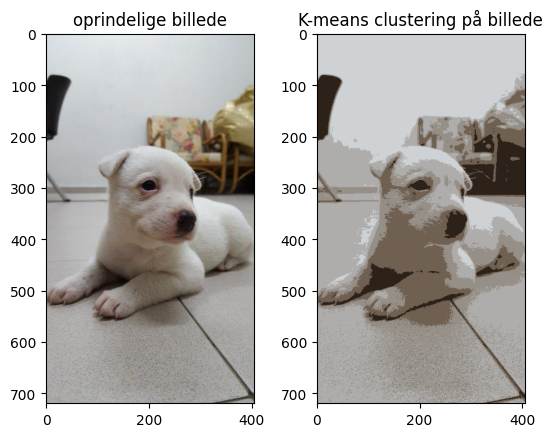

In [18]:
class Application(tk.Tk):
    current_image_path = 'Not set yet'
    def __init__(self):
        super().__init__()

        self.window_width = "800"
        self.window_height = "700"
        self.geometry(self.window_width+"x"+self.window_height)

        self.model_holder = ModelHolder()

        self.checkbutton_frame = tk.Frame(self)

        self.labels = ["Subject Focus", "Eyes", "Face", "Near", "Action", "Accessory", "Group", "Collage", "Human", "Occlusion", "Info", "Blur"]
        self.check_vars = {}
        self.num_columns = 6
        for i, label in enumerate(self.labels):
            var = tk.BooleanVar()
            self.check_vars[label] = var

            checkbutton = tk.Checkbutton(self.checkbutton_frame, text=label, variable=var)

            row = i // self.num_columns
            column = i % self.num_columns

            checkbutton.grid(row=row, column=column, sticky="w", padx=5, pady=5)

        self.button_frame = tk.Frame(self.checkbutton_frame)
        self.button_frame.grid(column= self.num_columns, row=0, rowspan=2)
        self.search_button = tk.Button(self.button_frame, text='Find billede (logistisk regression)', command=self.searchImage)
        self.search_with_nn_button = tk.Button(self.button_frame, text='Find billede (neural network)', command=self.searchImage_with_nn)

        self.result_frame = tk.Frame(self, height=400)
        self.score_Text = tk.Label(self.result_frame)

        self.image_frame = tk.Frame(self.result_frame, width=350)
        self.image_label = tk.Label(self.image_frame)
        self.image_kmeans_button = tk.Button(self.image_frame, text="Vis kmeans for billedet", command=self.show_image_kmeans)
        self.data_kmeans_button = tk.Button(self.image_frame, text="Vis kmeans for datasæt", command=self.show_data_kmeans)

        self.metrics_frame = tk.Frame(self.result_frame)
        self.header_font = font.Font(weight="bold", size=12)
        self.metrics_header_label = tk.Label(self.metrics_frame, text="Metrics", font=self.header_font)
        self.performance_measure_label = tk.Label(self.metrics_frame, text="Performance measure")
        self.cross_validation_label = tk.Label(self.metrics_frame, text="Cross validation")
        self.nn_evaluation_label = tk.Label(self.metrics_frame, text="NN evaluation")
        self.roc_curve_button = tk.Button(self.metrics_frame, text="Vis Roc Curve", command=self.show_roccurve)

        self.image_properties_label = tk.Label(self.result_frame)
        self.occlussion_label = tk.Label(self.result_frame)
        self.cat_or_dog_label = tk.Label(self.result_frame)
        self.all_labels_cnn_label = tk.Label(self.result_frame)

        self.options_frame = tk.Frame(self)

        self.pawpularity_options_frame = tk.Frame(self.options_frame)
        self.pawpularity_options_header = tk.Label(self.pawpularity_options_frame, text="Vælg model til at forudsige score", wraplength=200, font=self.header_font)
        self.choose_lin_reg_button = tk.Button(self.pawpularity_options_frame, text="Vælg lineær regression", command=self.use_lin_reg_for_pawpularity)
        
        self.human_options_frame = tk.Frame(self.options_frame)
        self.human_options_header = tk.Label(self.human_options_frame, text="Vælg model til at forudsige om der er menneske på billedet", wraplength=200, font=self.header_font)

        self.choose_log_reg_for_human_button = tk.Button(self.human_options_frame, text="Vælg logistisk regression", command=self.use_log_reg_for_human)
        self.choose_nn_for_human_button = tk.Button(self.human_options_frame, text="Vælg Neural network", command=self.use_nn_for_human)
        self.choose_ens_methods_for_human_button = tk.Button(self.human_options_frame, text="Vælg ensemble metoder", command=self.use_ens_methods_for_human)

        self.occlusion_options_frame = tk.Frame(self.options_frame)
        self.occlusion_options_header = tk.Label(self.occlusion_options_frame, text="Vælg model til at forudsige om der er occlusion på billedet", wraplength=200, font=self.header_font)
        self.choose_bayes_for_occlusion_button = tk.Button(self.occlusion_options_frame, text="Vælg Bayes", command=self.use_bayes_for_occlusion)
        self.choose_ensemble_methods_for_occlusion_button = tk.Button(self.occlusion_options_frame, text="Vælg Ensemble metoder", command=self.use_ens_methods_for_occlusion)

        # Packing
        self.checkbutton_frame.pack(padx=10, pady=10)

        # self.button_frame.pack(padx=10, pady=10)
        self.search_button.pack()
        self.search_with_nn_button.pack()

        self.result_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        self.score_Text.pack()

        self.image_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.image_label.pack()
        self.data_kmeans_button.pack()

        self.metrics_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        self.metrics_header_label.pack()
        self.performance_measure_label.pack(anchor="w")
        self.cross_validation_label.pack(anchor="w")
        self.roc_curve_button.pack()

        self.image_properties_label.pack()
        self.occlussion_label.pack()
        self.cat_or_dog_label.pack()
        self.all_labels_cnn_label.pack()

        self.options_frame.pack(padx=10, pady=10)

        self.pawpularity_options_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.pawpularity_options_header.pack()
        self.choose_lin_reg_button.pack()

        self.human_options_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.human_options_header.pack()
        self.choose_log_reg_for_human_button.pack()
        self.choose_nn_for_human_button.pack()
        self.choose_ens_methods_for_human_button.pack()

        self.occlusion_options_frame.pack(padx=10, pady=10, side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.occlusion_options_header.pack()
        self.choose_bayes_for_occlusion_button.pack()
        self.choose_ensemble_methods_for_occlusion_button.pack()

        self.image_search_result = pd.DataFrame()
        self.displayed_image_row = pd.Series()
    
    def searchImage(self):
        self.image_search_result = train_data.loc[(train_data["Subject Focus"] == self.check_vars["Subject Focus"].get()) & (train_data["Eyes"] ==self.check_vars["Eyes"].get()) & (train_data["Face"] == self.check_vars["Face"].get()) & (train_data["Near"] == self.check_vars["Near"].get()) & (train_data["Action"] == self.check_vars["Action"].get()) & (train_data["Accessory"] == self.check_vars["Accessory"].get()) & (train_data["Group"] == self.check_vars["Group"].get()) & (train_data["Collage"] == self.check_vars["Collage"].get()) & (train_data["Human"] == self.check_vars["Human"].get()) & (train_data["Occlusion"] == self.check_vars["Occlusion"].get()) & (train_data["Info"] == self.check_vars["Info"].get()) & (train_data["Blur"] == self.check_vars["Blur"].get())]
        self.use_log_reg_for_human()
        if not (self.displayed_image_row.isnull().all()):
            name = self.displayed_image_row.name
            img_url = f"Data\\train\\{str(name)}.jpg"
            self.display_image(img_url)
            self.use_lin_reg_for_pawpularity()
            self.update_cross_validation_label()
            self.update_cat_or_dog_label(img_url)
            self.update_all_labels_cnn_label(img_url)
            self.image_kmeans_button.pack()
            self.data_kmeans_button.pack_forget()
            self.data_kmeans_button.pack()
        else:
            self.image_label.config(text="Der var ikke nogle billeder med de valgte værdier")
    
    def searchImage_with_nn(self):
        self.image_search_result = train_data.loc[(train_data["Subject Focus"] == self.check_vars["Subject Focus"].get()) & (train_data["Eyes"] ==self.check_vars["Eyes"].get()) & (train_data["Face"] == self.check_vars["Face"].get()) & (train_data["Near"] == self.check_vars["Near"].get()) & (train_data["Action"] == self.check_vars["Action"].get()) & (train_data["Accessory"] == self.check_vars["Accessory"].get()) & (train_data["Group"] == self.check_vars["Group"].get()) & (train_data["Collage"] == self.check_vars["Collage"].get()) & (train_data["Human"] == self.check_vars["Human"].get()) & (train_data["Occlusion"] == self.check_vars["Occlusion"].get()) & (train_data["Info"] == self.check_vars["Info"].get()) & (train_data["Blur"] == self.check_vars["Blur"].get())]
        self.use_nn_for_human()
        if not (self.displayed_image_row.isnull().all()):
            name = self.displayed_image_row.name
            img_url = f"Data\\train\\{str(name)}.jpg"
            self.display_image(img_url)
            self.use_lin_reg_for_pawpularity()
            self.update_cross_validation_label()
            self.update_cat_or_dog_label(img_url)
            self.update_all_labels_cnn_label(img_url)
            self.image_kmeans_button.pack()
            self.data_kmeans_button.pack_forget()
            self.data_kmeans_button.pack()
        else:
            self.image_label.config(text="Der var ikke nogle billeder med de valgte værdier")

    def detect_human_with_logistic_regression(self, reg, data_row):
        columns = ["Occlusion", "Near", "Subject Focus", "Group"]
        return reg.predict(pd.DataFrame([data_row], columns=columns))

    def detect_human_with_nn(self, tensor):
        self.model_holder.nn_model.eval()
        with torch.no_grad():
            y_pred = self.model_holder.nn_model(tensor)
        return y_pred.item()

    def score_image_with_linear_regression(self, reg, data_row: pd.Series):
        data_row = data_row.drop(["Pawpularity"])
        return reg.predict(data_row.to_frame().transpose())

    def display_image(self, path: str):
        img = Image.open(path)
        height = 250
        img = self.resize_image(img,height = height)
        tk_img = ImageTk.PhotoImage(img)
        self.image_label.configure(image=tk_img)
        self.image_label.image = tk_img
        

    def show_image_window(self, path: str):
        img = Image.open(path)
        image = ImageTk.PhotoImage(img)
        window = tk.Toplevel(self)
        window.title("Image Viewer")
        
        label = tk.Label(window, image=image)
        label.image = image
        label.pack()
    
    def show_image_kmeans(self):
        path = "Data/train/" + self.displayed_image_row.name + ".jpg"
        image_kmeans(path)
        self.show_image_window("static/clustered_image.png")

    def show_data_kmeans(self):
        path = "static/kmeansplot4_scale_pca.png"
        self.show_image_window(path)

    def show_roccurve(self):
        path = "static\\roccurve_logisticregression.png"
        self.show_image_window(path)

    def resize_image(self, img: pil.Image.Image, height: int = 200, width: int = None):
        if (width == None):
            ratio = img.width/img.height
            width = int(ratio*height)
            return img.resize((width,height), Image.LANCZOS)
        else:
            ratio = img.height/img.width
            height = int(ratio*width)
            return img.resize((width,height), Image.LANCZOS)
    
    def update_image_label(self):
        img_url = f"Data\\train\\{str(self.displayed_image_row.name)}.jpg"
        self.display_image(img_url)

    def update_performance_measure_label(self):
        measure = get_performancemetrics(self.model_holder.log_reg_for_human,logiX_test,logiy_test,"logisticregression")
        self.performance_measure_label.config(text="Performance measures:\n" + measure)

    def update_cross_validation_label(self):
        scores = do_crossvalidation()
        self.cross_validation_label.config(text="Cross validation scores:\n" + scores)

    # def update_nn_evaluation_label(self):
    #     evaluation = nn_test_accuracy
    #     self.nn_evaluation_label.config(text="Neural network evaluation score:\n" + str(evaluation))

    def update_cat_or_dog_label(self, path):
        result = self.use_cnn_for_cat_or_dog(path)
        cat_or_dog = "Cat" if result == 0 else "Dog"

        self.cat_or_dog_label.config(text="Image is a " + cat_or_dog)
    
    def update_all_labels_cnn_label(self, path):
        result = self.use_cnn_for_all_labels(path)

        labels_string = "Image contains: " + ", ".join(result)

        self.all_labels_cnn_label.config(text=labels_string)
    
    def update_image_properties_label(self):
        properties = ""
        self.image_properties_label.config(text="Poperties: " + properties)
    
    def update_occlusion_label(self, content):
        self.image_properties_label.config(text="Er der occlusion? " + content)

    def use_lin_reg_for_pawpularity(self):
        score = self.score_image_with_linear_regression(self.model_holder.lin_reg, self.displayed_image_row)
        actual_score = self.displayed_image_row["Pawpularity"]
        self.score_Text.config(text="predicted score = " + str(score[0]) + ". Actual score = " + str(actual_score))

    def use_log_reg_for_human(self):
        if len(self.image_search_result) > 0:
            for idx, row in self.image_search_result.iterrows():
                if self.detect_human_with_logistic_regression(self.model_holder.log_reg_for_human, row) == 0:
                    self.displayed_image_row = row
                    self.update_image_label()
                    break
            self.update_performance_measure_label()
    
    def use_nn_for_human(self):
        if len(self.image_search_result) > 0:
            columns = ["Occlusion", "Near", "Subject Focus", "Group"]
            for idx, row in self.image_search_result.iterrows():
                modified_row = row[columns].values.astype(float)
                tensor = torch.tensor(modified_row, dtype=torch.float32)
                nn_model = self.model_holder.nn_model
                nn_model.eval()
                with torch.no_grad():
                    y_pred = nn_model(tensor)
                    a = y_pred.item()
                # human = trained_nn_model(tensor)
                if y_pred.item() < 0.5:
                    self.displayed_image_row = row
                    self.update_image_label()
                    break
    
    def use_bayes_for_occlusion(self):
        columns = ["Pawpularity", "Occlusion"]
        row = self.displayed_image_row.drop(columns)
        g_result = self.model_holder.gaussian_bayes_model.predict(row.to_frame().transpose())
        m_result = self.model_holder.multinomial_bayes_model.predict(row.to_frame().transpose())
        gauss = "Ja" if g_result == 1 else "Nej"
        multinomial = "Ja" if m_result == 1 else "Nej"
        occlusion = "\nGaussian: " + gauss + "\nMultinomial: " + multinomial
        self.update_occlusion_label(occlusion)
    
    def use_ens_methods_for_occlusion(self):
        columns = ["Pawpularity", "Occlusion"]
        row = self.displayed_image_row.drop(columns)
        df = row.to_frame().transpose()
        bag_res = self.model_holder.rfc_bagging_model.predict(df)
        boos_res = self.model_holder.decisionTree_boosting_model.predict(df)
        stack_res = self.model_holder.stacking_model.predict(df)
        bagging = "Ja" if bag_res == 1 else "Nej"
        boosting = "Ja" if boos_res == 1 else "Nej"
        stacking = "Ja" if stack_res == 1 else "Nej"
        occlusion = "\nBagging: " + bagging + "\nBoosting: " + boosting + "\nStacking: " + stacking
        self.update_occlusion_label(occlusion)

    
    def use_ens_methods_for_human(self):
        pass

    def use_cnn_for_cat_or_dog (self, path):
        image = Image.open(path)
        tensor_image = transform(image).unsqueeze(0)  # Add batch dimension
        CNN_model = self.model_holder.cnn_model.eval()
        with torch.no_grad(): 
            outputs = CNN_model(tensor_image)
            _, predicted = torch.max(outputs, 1)
        return predicted
    
    def use_cnn_for_all_labels (self, path):
        image = Image.open(path).convert('RGB')
        tensor_image = transform(image).unsqueeze(0)  # Add batch dimension
        multi_model = self.model_holder.all_labels_model
        multi_model.eval() 
        with torch.no_grad(): 
            outputs = multi_model(tensor_image)
            predictions = torch.sigmoid(outputs).squeeze().numpy()
            label_columns = self.displayed_image_row.drop(["Pawpularity"]).index
            predicted_labels = [label_columns[i] for i in range(len(label_columns)) if predictions[i] > 0.5]
            print(predicted_labels)
        return predicted_labels

if __name__ == "__main__":
    app = Application()
    app.mainloop()